In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


2023-02-27 12:27:05.871405: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In this experiment I'm going to show how to set the optimal bias initialization for your neural network. In particular, I'll use a subset of the cifat10 dataset, with unbalanced classes. Then, I'll train two network with this dataset, one with an optimized bias initialization and another one with a standard bias initialization.

The mathematical details can be found in my blog post (https://www.amolas.dev/blog/bias-initialization/)

# Load and prepare the data

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [3]:
image_dim = x_train.shape[1:] 

In [4]:
x_train = x_train / 255.
x_test = x_test / 255.
y_train = y_train.ravel()
y_test = y_test.ravel()

# Take a sample of the dataset.

In [5]:
# for each class define how many examples do you want to get in the sampled dataset
samples = {0: 4000,
           1: 3700,
           2: 100,
           3: 4000,
           4: 400,
           5: 100,
           6: 50,
           7: 700,
           8: 700,
           9: 100}
total = sum(samples.values())

In [6]:
X_train = []
Y_train = []
acc = {i:0 for i in range(10)}
for image, label in zip(x_train, y_train):
    if acc[label] < samples[label]:
        X_train.append(image)
        Y_train.append(label)
        acc[label] += 1
X_train = np.array(X_train)
Y_train = tf.keras.utils.to_categorical(Y_train)

# Define the models

In [20]:
# Standard CNN approach.

def get_model(optimal_bias=True):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    if optimal_bias:
        initial_bias = tf.constant_initializer([np.log(samples[i]/total) for i in range(10)])
        output_layer = tf.keras.layers.Dense(units=10, 
                                             bias_initializer=initial_bias,
                                             activation='softmax')
    else:
        initial_bias = tf.constant_initializer([0 for i in range(10)])
        output_layer = tf.keras.layers.Dense(units=10, 
                                             bias_initializer=initial_bias, 
                                             activation='softmax')
    model.add(output_layer)
    model.compile(
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
        optimizer=tf.keras.optimizers.RMSprop(),
        metrics=["accuracy"],
    )
    return model

In [21]:
# Get the models
normal_model = get_model(optimal_bias=False)
opt_bias_model = get_model(optimal_bias=True)

## Run some checks

In [22]:
# expected loss from using a non-informative initialization
exp = -sum([n_i/total * np.log(1/10) for n_i in samples.values()])

# actual loss
pretrain_preds = normal_model.predict(X_train, verbose=False)
act = np.mean(tf.keras.losses.categorical_crossentropy(Y_train, pretrain_preds))

print("Non-optimized model")
print(f"    Expected pre-training loss {exp}")
print(f"    Actual pre-training loss {act}")

Non-optimized model
    Expected pre-training loss 2.3025850929940463
    Actual pre-training loss 2.313023567199707


In [23]:
# expected loss from using an optimal initialization
exp = -sum([n_i/total * np.log(n_i/total) for n_i in samples.values()])

# actual loss
pretrain_preds = opt_bias_model.predict(X_train, verbose=False)
act = np.mean(tf.keras.losses.categorical_crossentropy(Y_train, pretrain_preds))

print("Non-optimized model")
print(f"    Expected pre-training loss {exp}")
print(f"    Actual pre-training loss {act}")

Non-optimized model
    Expected pre-training loss 1.6012265347398464
    Actual pre-training loss 1.6016318798065186


# Train model

In [24]:
# Define this callback to have access to training loss at every batch

class BatchLossCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.batch_losses = []

    def on_train_batch_end(self, batch, logs={}):
        self.batch_losses.append(logs.get('loss'))


In [25]:
epochs = 5
batch_size = 256

normal_callback = BatchLossCallback()
normal_history = normal_model.fit(X_train, 
                                  Y_train, 
                                  batch_size=batch_size, 
                                  epochs=epochs, 
                                  callbacks=[normal_callback])

opt_bias_callback = BatchLossCallback()
opt_bias_history = opt_bias_model.fit(X_train, 
                                      Y_train, 
                                      batch_size=batch_size, 
                                      epochs=epochs, 
                                      callbacks=[opt_bias_callback])

Epoch 1/5
55/55 [==============================] - 4s 74ms/step - loss: 1.5599 - accuracy: 0.4097
Epoch 2/5
55/55 [==============================] - 4s 78ms/step - loss: 1.2585 - accuracy: 0.5781
Epoch 3/5
55/55 [==============================] - 5s 98ms/step - loss: 1.1248 - accuracy: 0.6288
Epoch 4/5
55/55 [==============================] - 5s 89ms/step - loss: 1.0559 - accuracy: 0.6592
Epoch 5/5
55/55 [==============================] - 4s 79ms/step - loss: 0.9941 - accuracy: 0.6760
Epoch 1/5
55/55 [==============================] - 5s 76ms/step - loss: 1.4527 - accuracy: 0.4681
Epoch 2/5
55/55 [==============================] - 4s 78ms/step - loss: 1.1875 - accuracy: 0.6113
Epoch 3/5
55/55 [==============================] - 4s 77ms/step - loss: 1.0656 - accuracy: 0.6542
Epoch 4/5
55/55 [==============================] - 4s 81ms/step - loss: 0.9776 - accuracy: 0.6834
Epoch 5/5
55/55 [==============================] - 4s 77ms/step - loss: 0.9294 - accuracy: 0.6993


# Show the results

In the plot below we see that the optimized model converges faster and the initial loss is lower that the non-optimal model.

(0.0, 200.0)

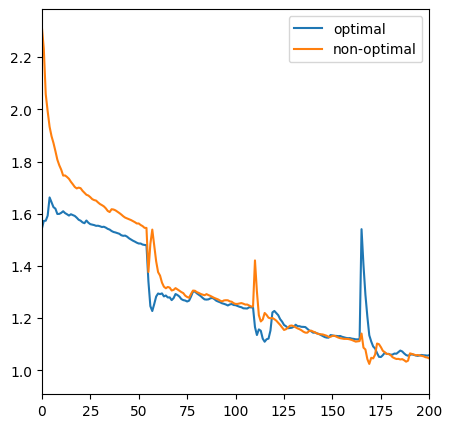

In [16]:
plt.figure(figsize=(5, 5))
plt.plot(opt_bias_callback.batch_losses, label="optimal")
plt.plot(normal_callback.batch_losses, label="non-optimal")
plt.legend()
plt.xlim([0, 200])